In [1]:
import glob
import os
import pathlib
import parse_access_cm2_results as par
import plot_pandas_data as ppd
import plot_right_axis_time as pra
from convert_time import days_to_gregorian_years, gregorian_years_to_days
from numpy import linspace

In [2]:
um_atmos_archive_dir = pathlib.PurePath("../access-cm2/cm2_test/archive/")
work_dir_glob = os.path.join(um_atmos_archive_dir, "work.*.bench")
work_dir_list = glob.glob(work_dir_glob)

In [3]:
df = par.parse_all(work_dir_list)

In [4]:
bw = lambda d: d[d["npes_per_node"] % 7 == 0]
cl = lambda d: d[d["npes_per_node"] % 6 == 0]

In [5]:
full = lambda d: d[d["npes_per_node"] >= 28]
half = lambda d: d[(d["npes_per_node"] == 14) | (d["npes_per_node"]) == 24]
qrtr = lambda d: d[(d["npes_per_node"] == 7) | (d["npes_per_node"]) == 12]

In [6]:
atm1 = lambda d: d[d["atm_cols"] != 28]
atm2 = lambda d: d[d["atm_cols"] == 28]

In [7]:
ocn0 = lambda d: d[d["ocn_npes"] == 64]
ocn1 = lambda d: d[d["ocn_npes"] == 128]
ocn2 = lambda d: d[d["ocn_npes"] == 256]

In [8]:
omp1 = lambda d: d[d["omp_num_threads"] == 1]
omp2 = lambda d: d[d["omp_num_threads"] == 2]

In [9]:
print(df.shape)

(83, 411)


In [10]:
xticks_ncpus = lambda d: d["ncpus"].sort_values().unique()
xticks_npes  = lambda d: d["npes"].sort_values().unique()

In [11]:
data=cl(ocn1(omp1(full(df))))

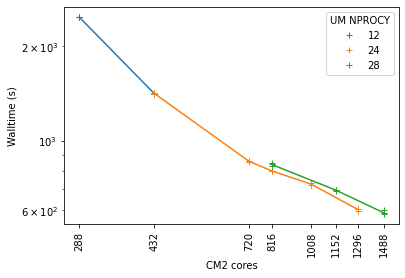

In [12]:
ppd.loglog_by_group("ncpus","walltime",
    by=["atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="Walltime (s)",
    xticks=xticks_ncpus(data),               
    right_axis_fn=pra.no_right_axis,
    legend_title="UM NPROCY")

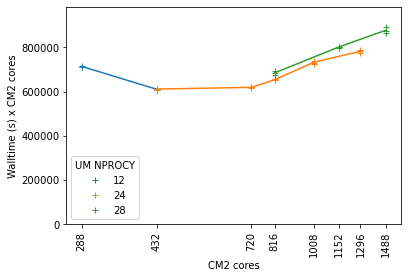

In [13]:
ppd.semilogx_by_group("ncpus","walltime * ncpus",
    by=["atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="Walltime (s) x CM2 cores",
    xticks=xticks_ncpus(data),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="UM NPROCY")

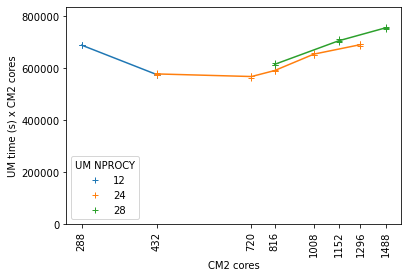

In [14]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus",
    by=["atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM time (s) x CM2 cores",
    xticks=xticks_ncpus(data),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="UM NPROCY")

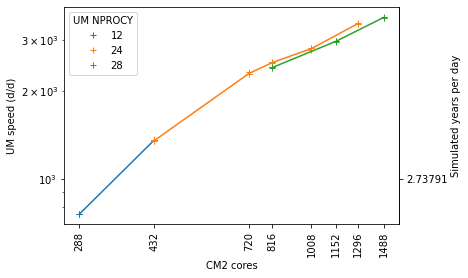

In [15]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(data),               
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="UM NPROCY")

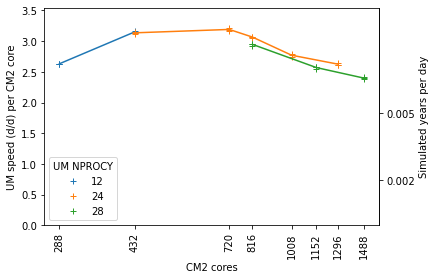

In [16]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_ncpus(data),
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="UM NPROCY")

In [17]:
def print_speed(speeds):
    print("CPUs d/d  Y/d")
    for ncpus in speeds:
        speed = speeds[ncpus]
        print(
            f"{ncpus:-4}",
            round(speed,2),
            round(days_to_gregorian_years(speed),5))

In [18]:
def print_speed_per_cpu(speeds_per_cpu):
    print("CPUs d/d  Y/d")
    for ncpus in speeds_per_cpu:
        speed = speeds_per_cpu[ncpus]
        print(
            f"{ncpus:-4}",
            round(speed,2),
            round(days_to_gregorian_years(speed),5))

In [19]:
def derive_mean_speed(df, by="atm_cols"):
    mean_speed = dict()
    group_cols = df.groupby(by)
    for name, group in group_cols:
        group_by_ncpus = group.groupby("ncpus")
        ncpus_list = group_by_ncpus.groups.keys()
        mean_by_ncpus = group_by_ncpus.mean()
        mean_speeds = mean_by_ncpus["Atm_Step_4A (AS) speed"]
        mean_speed[name] = {
           ncpus: mean_speeds[ncpus] for ncpus in ncpus_list}
    return mean_speed

In [20]:
def derive_mean_speed_per_cpu(df, by="atm_cols"):
    mean_speed_per_cpu = dict()
    group_cols = df.groupby(by)
    for name, group in group_cols:
        group_by_ncpus = group.groupby("ncpus")
        ncpus_list = group_by_ncpus.groups.keys()
        mean_by_ncpus = group_by_ncpus.mean()
        mean_speeds = mean_by_ncpus["Atm_Step_4A (AS) speed"]
        mean_speed_per_cpu[name] = {
           ncpus: mean_speeds[ncpus]/ncpus for ncpus in ncpus_list}
    return mean_speed_per_cpu

In [21]:
mean_speed_per_cpu = derive_mean_speed_per_cpu(
    data,
    by="atm_cols")
    
print("Mean speed per CM2 core for UM NPROCY: 12")
print_speed_per_cpu(mean_speed_per_cpu[12])
print("Mean speed per CM2 core for UM NPROCY: 24")
print_speed_per_cpu(mean_speed_per_cpu[24])
print("Mean speed per CM2 core for UM NPROCY: 28")
print_speed_per_cpu(mean_speed_per_cpu[28])

speed_24x12_vs_12x24 = round(
    mean_speed_per_cpu[12][432]/mean_speed_per_cpu[24][432],3)
speed_28x24_vs_24x28=round(
    mean_speed_per_cpu[24][816]/mean_speed_per_cpu[28][816],3)

print("Speed at 24 x 12 vs 12 x 24")
print(speed_24x12_vs_12x24)
print("Speed at 28 x 24 vs 24 x 28")
print(speed_28x24_vs_24x28)

Mean speed per CM2 core for UM NPROCY: 12
CPUs d/d  Y/d
 288 2.63 0.00721
 432 3.15 0.00862
Mean speed per CM2 core for UM NPROCY: 24
CPUs d/d  Y/d
 432 3.14 0.00858
 720 3.19 0.00874
 816 3.07 0.0084
1008 2.77 0.00759
1296 2.62 0.00719
Mean speed per CM2 core for UM NPROCY: 28
CPUs d/d  Y/d
 816 2.95 0.00807
1152 2.57 0.00704
1488 2.4 0.00657
Speed at 24 x 12 vs 12 x 24
1.005
Speed at 28 x 24 vs 24 x 28
1.04


In [22]:
data=cl(ocn1(atm1(df)))

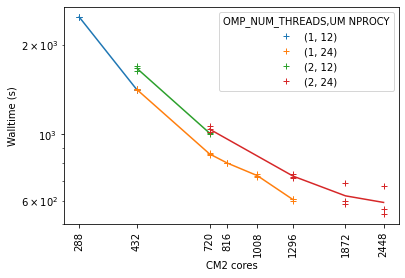

In [23]:
ppd.loglog_by_group("ncpus","walltime",
    by=["omp_num_threads","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="Walltime (s)",
    xticks=xticks_ncpus(data),               
    right_axis_fn=pra.no_right_axis,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

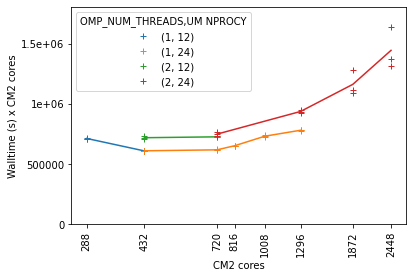

In [24]:
ppd.semilogx_by_group("ncpus","walltime * ncpus",
    by=["omp_num_threads","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="Walltime (s) x CM2 cores",
    xticks=xticks_ncpus(data),
    yticks=linspace(0,1500000,4),
    right_axis_fn=pra.no_right_axis,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

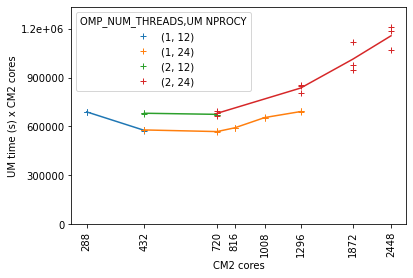

In [25]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus",
    by=["omp_num_threads","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM time (s) x CM2 cores",
    xticks=xticks_ncpus(data),
    yticks=linspace(0,1200000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

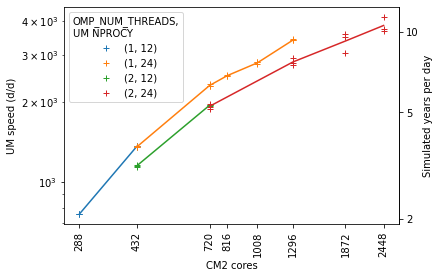

In [26]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["omp_num_threads","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(data),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OMP_NUM_THREADS,\nUM NPROCY")

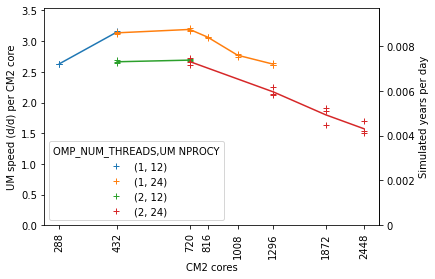

In [27]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["omp_num_threads","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_ncpus(data),               
    right_yticks=linspace(0,0.01,6),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="OMP_NUM_THREADS,UM NPROCY")

In [28]:
mean_speed_per_cpu = derive_mean_speed_per_cpu(
    data,
    by=["omp_num_threads","atm_cols"])
print("Mean speed per CM2 core for OMP_NUM_THREADS: 1, UM NPROCY: 12")
print_speed_per_cpu(mean_speed_per_cpu[(1,12)])
print("Mean speed per CM2 core for OMP_NUM_THREADS: 1, UM NPROCY: 24")
print_speed_per_cpu(mean_speed_per_cpu[(1,24)])
print("Mean speed per CM2 core for OMP_NUM_THREADS: 2, UM NPROCY: 12")
print_speed_per_cpu(mean_speed_per_cpu[(2,12)])
print("Mean speed per CM2 core for OMP_NUM_THREADS: 2, UM NPROCY: 24")
print_speed_per_cpu(mean_speed_per_cpu[(2,24)])

speed_omp1_vs_omp2 = dict()
speed_omp1_vs_omp2[432] = round(
    mean_speed_per_cpu[(1,12)][432]/mean_speed_per_cpu[(2,12)][432],2)
for ncpus in [720, 1296]:
    speed_omp1_vs_omp2[ncpus] = round(
        mean_speed_per_cpu[(1,24)][ncpus]/mean_speed_per_cpu[(2,24)][ncpus],2)
for ncpus in [432, 720, 1296]:
    print(f"Speed for 1 thread vs 2 threads for {ncpus} cores")
    print(speed_omp1_vs_omp2[ncpus])

Mean speed per CM2 core for OMP_NUM_THREADS: 1, UM NPROCY: 12
CPUs d/d  Y/d
 288 2.63 0.00721
 432 3.15 0.00862
Mean speed per CM2 core for OMP_NUM_THREADS: 1, UM NPROCY: 24
CPUs d/d  Y/d
 432 3.14 0.00858
 720 3.19 0.00874
 816 3.07 0.0084
1008 2.77 0.00759
1296 2.62 0.00719
Mean speed per CM2 core for OMP_NUM_THREADS: 2, UM NPROCY: 12
CPUs d/d  Y/d
 432 2.66 0.00729
 720 2.69 0.00737
Mean speed per CM2 core for OMP_NUM_THREADS: 2, UM NPROCY: 24
CPUs d/d  Y/d
 720 2.67 0.0073
1296 2.17 0.00595
1872 1.8 0.00493
2448 1.57 0.00431
Speed for 1 thread vs 2 threads for 432 cores
1.18
Speed for 1 thread vs 2 threads for 720 cores
1.2
Speed for 1 thread vs 2 threads for 1296 cores
1.21


In [29]:
data=cl(omp1(atm1(full(df))))

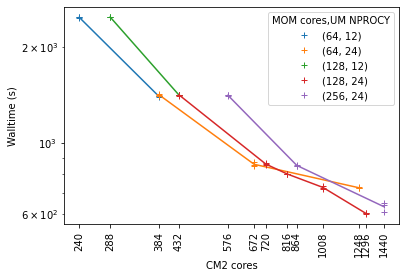

In [30]:
ppd.loglog_by_group("ncpus","walltime",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="Walltime (s)",
    xticks=xticks_ncpus(data),               
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM cores,UM NPROCY")

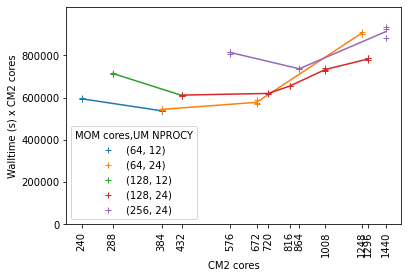

In [31]:
ppd.semilogx_by_group("ncpus","walltime * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="Walltime (s) x CM2 cores",
    xticks=xticks_ncpus(data),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM cores,UM NPROCY")

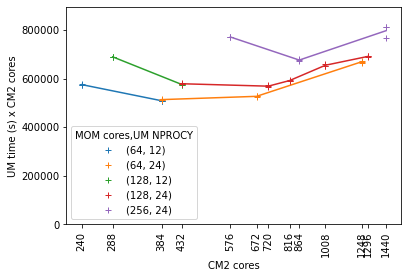

In [32]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM time (s) x CM2 cores",
    xticks=xticks_ncpus(data),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM cores,UM NPROCY")

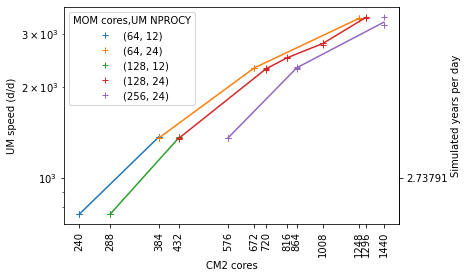

In [33]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(data),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM cores,UM NPROCY")

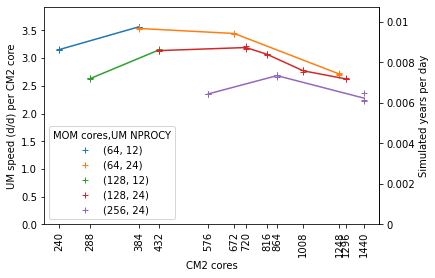

In [34]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_ncpus(data),               
    right_yticks=linspace(0,0.01,6),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM cores,UM NPROCY")

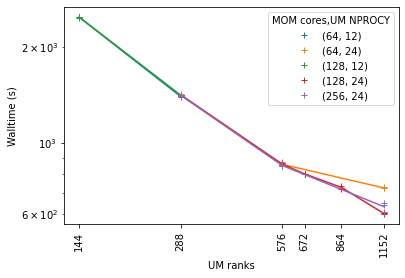

In [35]:
ppd.loglog_by_group("npes","walltime",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="Walltime (s)",
    xticks=xticks_npes(data),               
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM cores,UM NPROCY")

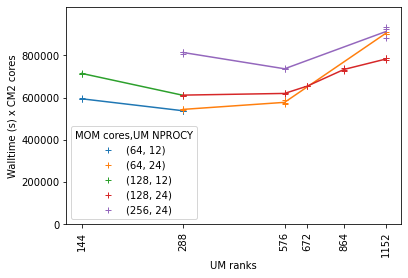

In [36]:
ppd.semilogx_by_group("npes","walltime * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="Walltime (s) x CM2 cores",
    xticks=xticks_npes(data),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM cores,UM NPROCY")

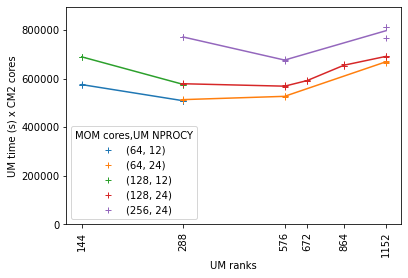

In [37]:
ppd.semilogx_by_group("npes","Atm_Step_4A (AS) * ncpus",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="UM time (s) x CM2 cores",
    xticks=xticks_npes(data),
    yticks=linspace(0,800000,5),
    right_axis_fn=pra.no_right_axis,
    legend_title="MOM cores,UM NPROCY")

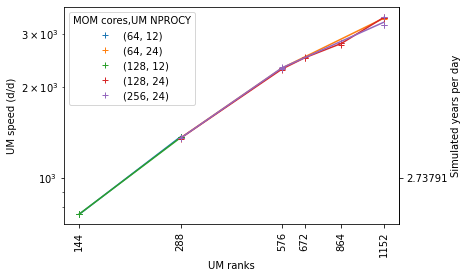

In [38]:
ppd.loglog_by_group("npes","Atm_Step_4A (AS) speed",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="UM speed (d/d)",
    xticks=xticks_npes(data),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM cores,UM NPROCY")

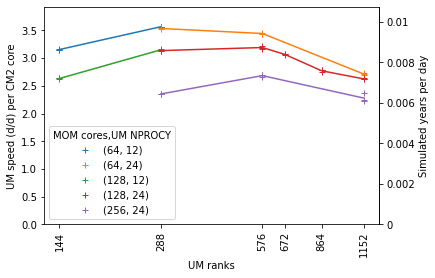

In [39]:
ppd.semilogx_by_group("npes","Atm_Step_4A (AS) * ncpus speed",
    by=["ocn_npes","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_npes(data),               
    right_yticks=linspace(0,0.01,6),
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="MOM cores,UM NPROCY")

In [40]:
series_speed_per_cpu = derive_mean_speed_per_cpu(
    data,
    by=["ocn_npes","atm_cols","npes"])
mean_speed_per_cpu = (
    lambda key:
    list(series_speed_per_cpu[key].items())[0][1])
print("MOM cores UM NPROCY UM Ranks Speed per CM2 core")
for key in series_speed_per_cpu:
    speed = mean_speed_per_cpu(key)
    print(f"{key[0]:-6}     {key[1]:-6}    {key[2]:-6}    {speed:-5.3}")
print("MOM cores: 64 vs 128")
print("UM NPROCY: 12")
print("UM Ranks Speedup")
for npes in [144, 288]:
    print(f"{npes:-6}   {mean_speed_per_cpu((64,12,npes))/mean_speed_per_cpu((128,12,npes)):-5.3}")
print("UM NPROCY: 24")
print("UM Ranks Speedup")
for npes in [288, 576, 1152]:
    print(f"{npes:-6}   {mean_speed_per_cpu((64,24,npes))/mean_speed_per_cpu((128,24,npes)):-5.3}")
print("MOM cores: 128 vs 256")
print("UM NPROCY: 24")
print("UM Ranks Speedup")
for npes in [288, 576, 1152]:
    print(f"{npes:-6}   {mean_speed_per_cpu((128,24,npes))/mean_speed_per_cpu((256,24,npes)):-5.3}")

MOM cores UM NPROCY UM Ranks Speed per CM2 core
    64         12       144     3.15
    64         12       288     3.57
    64         24       288     3.53
    64         24       576     3.44
    64         24      1152     2.71
   128         12       144     2.63
   128         12       288     3.15
   128         24       288     3.14
   128         24       576     3.19
   128         24       672     3.07
   128         24       864     2.77
   128         24      1152     2.62
   256         24       288     2.35
   256         24       576     2.68
   256         24      1152     2.28
MOM cores: 64 vs 128
UM NPROCY: 12
UM Ranks Speedup
   144     1.2
   288    1.13
UM NPROCY: 24
UM Ranks Speedup
   288    1.13
   576    1.08
  1152    1.03
MOM cores: 128 vs 256
UM NPROCY: 24
UM Ranks Speedup
   288    1.33
   576    1.19
  1152    1.15


In [41]:
npe144=lambda d:d[d["npes"] == 144]

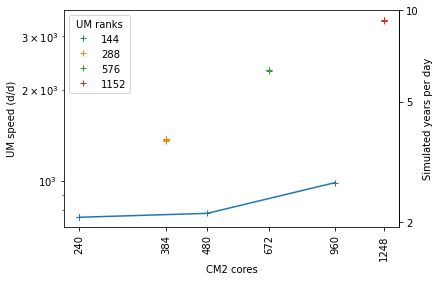

In [42]:
data=cl(ocn0(omp1(df)))
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["npes"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(data),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="UM ranks")

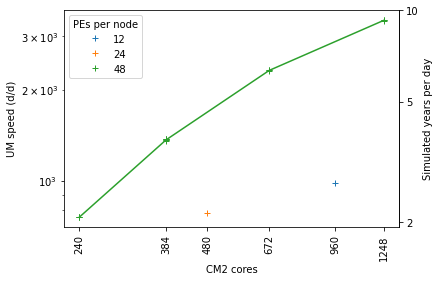

In [43]:
ppd.loglog_by_group("ncpus","Atm_Step_4A (AS) speed",
    by=["npes_per_node"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d)",
    xticks=xticks_ncpus(data),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="PEs per node")

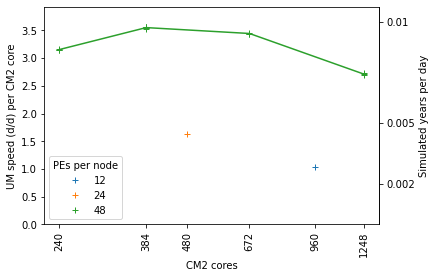

In [44]:
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["npes_per_node"], 
    data=data,
    xlabel="CM2 cores",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_ncpus(data),
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="PEs per node")

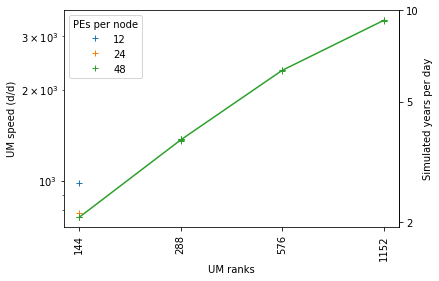

In [45]:
ppd.loglog_by_group("npes","Atm_Step_4A (AS) speed",
    by=["npes_per_node"], 
    data=data,
    xlabel="UM ranks",
    ylabel="UM speed (d/d)",
    xticks=xticks_npes(data),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="PEs per node")

In [46]:
data=ocn1(omp1(df))

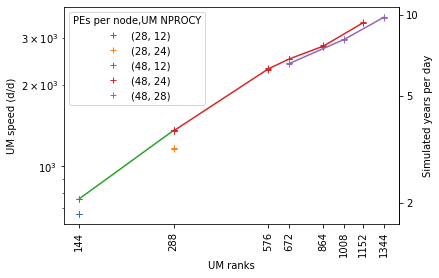

In [47]:
ppd.loglog_by_group("npes","Atm_Step_4A (AS) speed",
    by=["npes_per_node","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="UM speed (d/d)",
    xticks=xticks_npes(data),             
    right_yticks=[0.5,1,2,5,10],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="PEs per node,UM NPROCY")

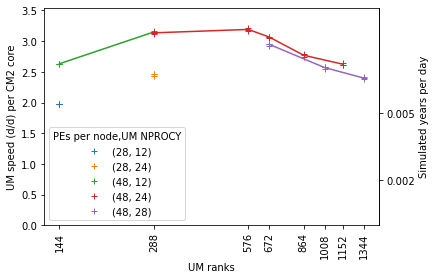

In [48]:
ppd.semilogx_by_group("npes","Atm_Step_4A (AS) * ncpus speed",
    by=["npes_per_node","atm_cols"], 
    data=data,
    xlabel="UM ranks",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_npes(data),
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="PEs per node,UM NPROCY")

In [49]:
series_speed = derive_mean_speed(
    data,
    by=["npes_per_node","atm_cols","npes"])
mean_speed = (
    lambda key:
    list(series_speed[key].items())[0][1])
print("MOM cores  UM NPROCY UM Ranks   Speed")
for key in series_speed:
    speed = mean_speed(key)
    print(f"{key[0]:-6}     {key[1]:-6}   {key[2]:-6}   {speed:-10.3}")
print("Cascade Lake vs Broadwell")
print("UM NPROCY: 12")
print("UM Ranks Speedup")
for npes in [144]:
    print(f"{npes:-6}   {mean_speed((48,12,npes))/mean_speed((28,12,npes)):-5.3}")
print("UM NPROCY: 24")
print("UM Ranks Speedup")
for npes in [288]:
    print(f"{npes:-6}   {mean_speed((48,24,npes))/mean_speed((28,24,npes)):-5.3}")

MOM cores  UM NPROCY UM Ranks   Speed
    28         12      144     6.65e+02
    28         24      288     1.17e+03
    48         12      144     7.58e+02
    48         12      288     1.36e+03
    48         24      288     1.35e+03
    48         24      576      2.3e+03
    48         24      672      2.5e+03
    48         24      864     2.79e+03
    48         24     1152      3.4e+03
    48         28      672     2.41e+03
    48         28     1008     2.96e+03
    48         28     1344     3.57e+03
Cascade Lake vs Broadwell
UM NPROCY: 12
UM Ranks Speedup
   144    1.14
UM NPROCY: 24
UM Ranks Speedup
   288    1.16


In [50]:
data.sort_values(["npes_per_node","omp_num_threads","ocn_npes","npes","atm_cols"])

,npes_per_node,service_units,ncpus,memory,jobfs,omp_num_threads,nbr_time_steps,seconds_per_time_step,exp_seconds,npes,...,AS Aerosol Modelling * npes speed,AS Diffusion * npes speed,AS Assimilation * npes speed,AP1 NI_methox * npes speed,AS Energy mass * npes speed,AP1 Energy Correct. * npes speed,AP2 Conv Eng Corr * npes speed,AP1 Conv Eng Corr * npes speed,AS IAU * npes speed,AS Stochastic_Phys * npes speed
6,28,327.25,336,165.92GB,8.11MB,1,1512,1200.0,1814400.0,144,...,13846.153846,90000.000000,57272.727273,96923.076923,126000.000000,252000.0,315000.0,210000.0,420000.0,420000.0
43,28,337.28,336,169.14GB,8.11MB,1,1512,1200.0,1814400.0,144,...,13846.153846,90000.000000,57272.727273,96923.076923,126000.000000,252000.0,315000.0,210000.0,315000.0,315000.0
59,28,328.65,336,168.65GB,8.11MB,1,1512,1200.0,1814400.0,144,...,13846.153846,84000.000000,57272.727273,96923.076923,126000.000000,252000.0,315000.0,210000.0,315000.0,315000.0
2,28,268.58,476,205.48GB,8.11MB,1,1512,1200.0,1814400.0,288,...,15750.000000,45000.000000,42000.000000,70000.000000,90000.000000,157500.0,157500.0,126000.0,210000.0,210000.0
11,28,275.52,476,206.54GB,8.11MB,1,1512,1200.0,1814400.0,288,...,15750.000000,45000.000000,42000.000000,70000.000000,90000.000000,157500.0,157500.0,126000.0,210000.0,210000.0
37,28,268.25,476,205.96GB,8.11MB,1,1512,1200.0,1814400.0,288,...,15750.000000,45000.000000,45000.000000,70000.000000,90000.000000,157500.0,210000.0,126000.0,210000.0,210000.0
0,48,396.48,288,166.6GB,8.16MB,1,1512,1200.0,1814400.0,144,...,12115.384615,57272.727273,54782.608696,90000.000000,105000.000000,140000.0,180000.0,210000.0,210000.0,252000.0
16,48,396.48,288,166.17GB,8.16MB,1,1512,1200.0,1814400.0,144,...,12115.384615,63000.000000,54782.608696,90000.000000,114545.454545,140000.0,210000.0,252000.0,252000.0,252000.0
17,48,397.76,288,166.39GB,8.16MB,1,1512,1200.0,1814400.0,144,...,12115.384615,57272.727273,54782.608696,90000.000000,114545.454545,140000.0,180000.0,210000.0,210000.0,252000.0
8,48,338.88,432,213.7GB,8.16MB,1,1512,1200.0,1814400.0,288,...,11886.792453,30000.000000,39375.000000,78750.000000,78750.000000,105000.0,105000.0,126000.0,126000.0,126000.0


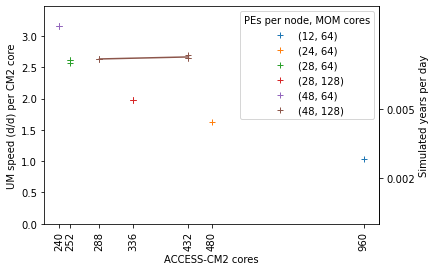

In [51]:
data=npe144(df)
ppd.semilogx_by_group("ncpus","Atm_Step_4A (AS) * ncpus speed",
    by=["npes_per_node","ocn_npes"], 
    data=data,
    xlabel="ACCESS-CM2 cores",
    ylabel="UM speed (d/d) per CM2 core",
    xticks=xticks_ncpus(data),
    right_yticks=[0.002,0.005,0.01,0.02],
    right_axis_fn=pra.plot_right_axis_yd,
    legend_title="PEs per node, MOM cores")

In [52]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [53]:
df_all.sort_values(["omp_num_threads","ocn_npes","npes","atm_cols"])

NameError: name 'df_all' is not defined